## Plotly plot of a graph with a circular layout ##

A circular layout places the graph nodes uniformly on a circle. In this Jupyter Notebook we illustrate how to  draw the graph edges in order to avoid a cluttered visualization.

As example we consider a circular graph having as nodes the  European countries. Among these countries some qualified for the grand final [Eurovision Song Contest](http://www.eurovision.tv/page/timeline).

Each european country is a jury member and rates some contestants on a scale from 1 to 12 (in 2015 a contestant from Australia led to adding this country to the graph).

There is a directed edge from a jury member country to a contestant country  if the contestant acquired at least one point from the jury country voters.

The jury member countries are placed uniformly, in alphabetical order, on the unit circle. If there is an edge between two nodes, then we draw a cubic [B&eacute;zier curve](http://nbviewer.ipython.org/github/empet/geom_modeling/blob/master/FP-Bezier-Bspline.ipynb) having  as the first and the last control point the given nodes. 

To avoid cluttered edges we adopted the following procedure in choosing the interior control points for the B&eacute;zier curve:

- we consider five  equally spaced  points on the unit circle, corresponding to the angles $0, \:\pi/4$ $\pi/2,\: 3\pi/4, \:\pi$: $$P_1(1,0), \: P_2=(\sqrt{2}/2,\: \sqrt{2}/2),\: P_3(0,1), \: P_4=(-\sqrt{2}/2, \sqrt{2}/2),\:  P_5(-1,0)$$

- define a list,  `Dist`, having as elements the distances between the following pairs of points:
$$(P_1, P_1), \:(P_1, P_2), \: (P_1, P_3),\: (P_1, P_4),\: (P_1, P_5)$$

- In order to assign the control poligon to the B&eacute;zier curve that will be the edge between two connected
nodes, `V[i], V[j]`, we compute the distance between these nodes, and deduce the interval $k$, of two consecutive values in `Dist`, this distance  belongs to.

- Since there are four such intervals indexed $k=0,1,2,3$, we  define the control poligon as follows: $${\bf b}_0=V[i],\:\: {\bf b}_1=V[i]/param,\:\: {\bf b}_2=V[j]/param, \:\:{\bf b}_3=V[j],$$ where `param` is chosen from the list: `params=[1.2, 1.5, 1.8, 2.1]`.

Namely, if the distance(`V[i], V[j]`), belongs to the $K^{th}$ interval associated to `Dist`, then we choose `param= params[K]`.


We processed  data provided by [Eurovision Song Contest](http://www.eurovision.tv/page/history/by-year/contest?event=2083#Scoreboard), and saved  the corresponding graph in a `gml` file. 

Now are reading the `gml` file and define  an [`igraph.Graph`](http://igraph.org/python/) object.

In [1]:
import igraph as ig

In [2]:
G=ig.Graph.Read_GML('Eurovision15.gml')

Define the list of nodes (vs stands for vertices):

In [3]:
V=list(G.vs) 
G.vs.attributes()# list node attributes

['id', 'label']

In [4]:
G.vs.attributes()# list node attributes

['id', 'label']

In [5]:
print V[0]

igraph.Vertex(<igraph.Graph object at 0x102f90620>,0,{'id': 0.0, 'label': 'Albania'})


Define the  label list. Labels  will be displayed in the Plotly plot:

In [6]:
labels=[v['label']  for v in V] 

`G.es` is the sequence of graph edges. 

In [7]:
G.es.attributes()# the edge attributes

['weight']

In [8]:
G.es[0]

igraph.Edge(<igraph.Graph object at 0x102f90620>, 0, {'weight': 2.0})

Get the edge list as a list of tuples, having as elements the end nodes indices:

In [9]:
E=[e.tuple for e in G.es]# list of edges
len(E)

400

Get the list of Contestant countries:

In [10]:
ContestantLst=[G.vs[e[1]] for e in E]
Contestant=list(set([v['label'] for  v in ContestantLst]))
len(Contestant)

25

Get the node positions, assigned by the circular layout:

In [11]:
layt=G.layout('circular') #circular layout

`layt` is a list of 2-elements lists, representing the coordinates of nodes placed on the unit circle:

In [12]:
L=len(layt)
layt[7]

[0.4539904997395468, 0.8910065241883678]

Define the list of edge weights:

In [13]:
Weights= map(int, G.es["weight"])

In the sequel we define a few functions that lead to the edge definition as a B&eacute;zier curve:

In [14]:
import numpy as np

`dist(A,B)` computes the distance between two 2D points, A, B:

In [15]:
def dist (A,B):
    return np.linalg.norm(np.array(A)-np.array(B))

In [16]:
dist(layt[0], layt[5])

0.76536686473017945

Define the list `Dist` of threshold distances between nodes on the unit circle:

In [17]:
Dist=[0, dist([1,0], 2*[np.sqrt(2)/2]), np.sqrt(2),
      dist([1,0],  [-np.sqrt(2)/2, np.sqrt(2)/2]), 2.0]
Dist

[0, 0.76536686473017967, 1.4142135623730951, 1.8477590650225735, 2.0]

The list of parameters for interior control points:

In [18]:
params=[1.2, 1.5, 1.8, 2.1]

The function `get_idx_interv` returns the index of the interval  the distance `d` belongs to:

In [19]:
def get_idx_interv(d, D):
    k=0
    while(d>D[k]): 
        k+=1
    return  k-1

Below are defined the function `deCasteljau`  and `BezierCv`. The former  returns the point corresponding to the parameter `t`, on a B&eacute;zier curve of control points given in the list `b`. 

The latter returns an array of shape (nr, 2) containing the coordinates of 
`nr` points evaluated on the B&eacute;zier curve, at equally spaced parameters in [0,1].

For our purpose the default number of points evaluated on a B&eacute;zier edge is 5. Then setting the Plotly `shape` of the edge line as `spline`, the five points are  interpolated.

In [20]:
class InvalidInputError(Exception):
    pass

In [21]:
def deCasteljau(b,t): 
    N=len(b) 
    if(N<2):
        raise InvalidInputError("The  control polygon must have at least two points")
    a=np.copy(b) #shallow copy of the list of control points 
    for r in range(1,N): 
        a[:N-r,:]=(1-t)*a[:N-r,:]+t*a[1:N-r+1,:]                             
    return a[0,:]

In [22]:
def BezierCv(b, nr=5):
    t=np.linspace(0, 1, nr)
    return np.array([deCasteljau(b, t[k]) for k in range(nr)]) 

Finally we set  data and layout for the Plotly plot of the circular graph:

In [23]:
import plotly.plotly as py
from plotly.graph_objs import *

Set node colors and line colors (the lines encircling the dots marking the nodes):

In [24]:
node_color=['rgba(0,51,181, 0.85)'  if v['label'] in Contestant else '#CCCCCC' for v in G.vs] 
line_color=['#FFFFFF'  if v['label'] in Contestant else 'rgb(150,150,150)' for v in G.vs]

The graph edges are colored with  colors depending on the distance between end nodes:

In [25]:
edge_colors=['#d4daff','#84a9dd', '#5588c8', '#6d8acf']

Define the lists of x, respectively y-coordinates of the nodes:

In [26]:
Xn=[layt[k][0] for k in range(L)]
Yn=[layt[k][1] for k in range(L)]

On each B&eacute;zier edge, at the point corresponding to the parameter $t=0.9$, one displays the source and the target node labels, as well as  the number of points (votes) assigned by source to target.

In [27]:
lines=[]# the list of dicts defining   edge  Plotly attributes
edge_info=[]# the list of points on edges where  the information is placed

for j, e in enumerate(E):
    A=np.array(layt[e[0]])
    B=np.array(layt[e[1]])
    d=dist(A, B)
    K=get_idx_interv(d, Dist)
    b=[A, A/params[K], B/params[K], B]
    color=edge_colors[K]
    pts=BezierCv(b, nr=5)
    text=V[e[0]]['label']+' to '+V[e[1]]['label']+' '+str(Weights[j])+' pts'
    mark=deCasteljau(b,0.9)
    edge_info.append(Scatter(x=mark[0], 
                             y=mark[1], 
                             mode='markers', 
                             marker=Marker( size=0.5,  color=edge_colors),
                             text=text, 
                             hoverinfo='text'
                             )
                    )
    lines.append(Scatter(x=pts[:,0],
                         y=pts[:,1],
                         mode='lines',
                         line=Line(color=color, 
                                  shape='spline',
                                  width=Weights[j]/5#The  width is proportional to the edge weight
                                 ), 
                        hoverinfo='none' 
                       )
                )

In [28]:
trace2=Scatter(x=Xn,
               y=Yn,
               mode='markers',
               name='',
               marker=Marker(symbol='dot',
                             size=15, 
                             color=node_color, 
                             line=Line(color=line_color, width=0.5)
                             ),
               text=labels,
               hoverinfo='text',
               )

In [29]:
axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )

In [30]:
def make_annotation(anno_text, y_coord):
    return Annotation(showarrow=False, 
                      text=anno_text,  
                      xref='paper',     
                      yref='paper',     
                      x=0,  
                      y=y_coord,  
                      xanchor='left',   
                      yanchor='bottom',  
                      font=Font(size=12)     
                     )

In [31]:
anno_text1='Blue nodes mark the countries that are both contestants and jury members'
anno_text2='Grey nodes mark the countries that are only jury members'
anno_text3='There is an edge from a Jury country to a contestant country '+\
           'if the jury country assigned at least one vote to that contestant'
width=800
height=850
title="A circular graph associated to Eurovision Song Contest, 2015<br>Data source:"+\
"<a href='http://www.eurovision.tv/page/history/by-year/contest?event=2083#Scoreboard'> [1]</a>"
layout=Layout(title= title,
              font= Font(size=12),
              showlegend=False,
              autosize=False,
              width=width,
              height=height,
              xaxis=XAxis(axis),
              yaxis=YAxis(axis),          
              margin=Margin(l=40,
                            r=40,
                            b=85,
                            t=100,
                          ),
              hovermode='closest',
              annotations=Annotations([make_annotation(anno_text1, -0.07), 
                                       make_annotation(anno_text2, -0.09),
                                       make_annotation(anno_text3, -0.11)]
                                     )
              )


In [33]:
data=Data(lines+edge_info+[trace2])
fig=Figure(data=data, layout=layout)
py.iplot(fig, filename='Eurovision-15') 

<div>
    <a href="https://plot.ly/~empet/9883/" target="_blank" title="A circular graph associated to Eurovision Song Contest, 2015&lt;br&gt;Data source:&lt;a href=&#39;http://www.eurovision.tv/page/history/by-year/contest?event=2083#Scoreboard&#39;&gt; [1]&lt;/a&gt;" style="display: block; text-align: center;"><img src="https://plot.ly/~empet/9883.png" alt="A circular graph associated to Eurovision Song Contest, 2015&lt;br&gt;Data source:&lt;a href=&#39;http://www.eurovision.tv/page/history/by-year/contest?event=2083#Scoreboard&#39;&gt; [1]&lt;/a&gt;" style="max-width: 100%;width: 800px;"  width="800" onerror="this.onerror=null;this.src='https://plot.ly/404.png';" /></a>
    <script data-plotly="empet:9883"  src="https://plot.ly/embed.js" async></script>
</div>



Let us compare the Plotly plot with  the igraph plot of the circular Graph:

In [34]:
ig.plot(G,   vertex_size=25, vertex_label_size=7, 
     edge_label_size=7,  layout=layt, 
     bbox=(0,0,550,550), vertex_color='#a1d99b' )

TypeError: plotting not available

Now we define and draw the Eurovision graph as a networkx.Graph:

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
G=nx.DiGraph()
G.add_nodes_from(range(L))
G.add_edges_from(E)

(-1.5, 1.5, -1.5, 1.5)

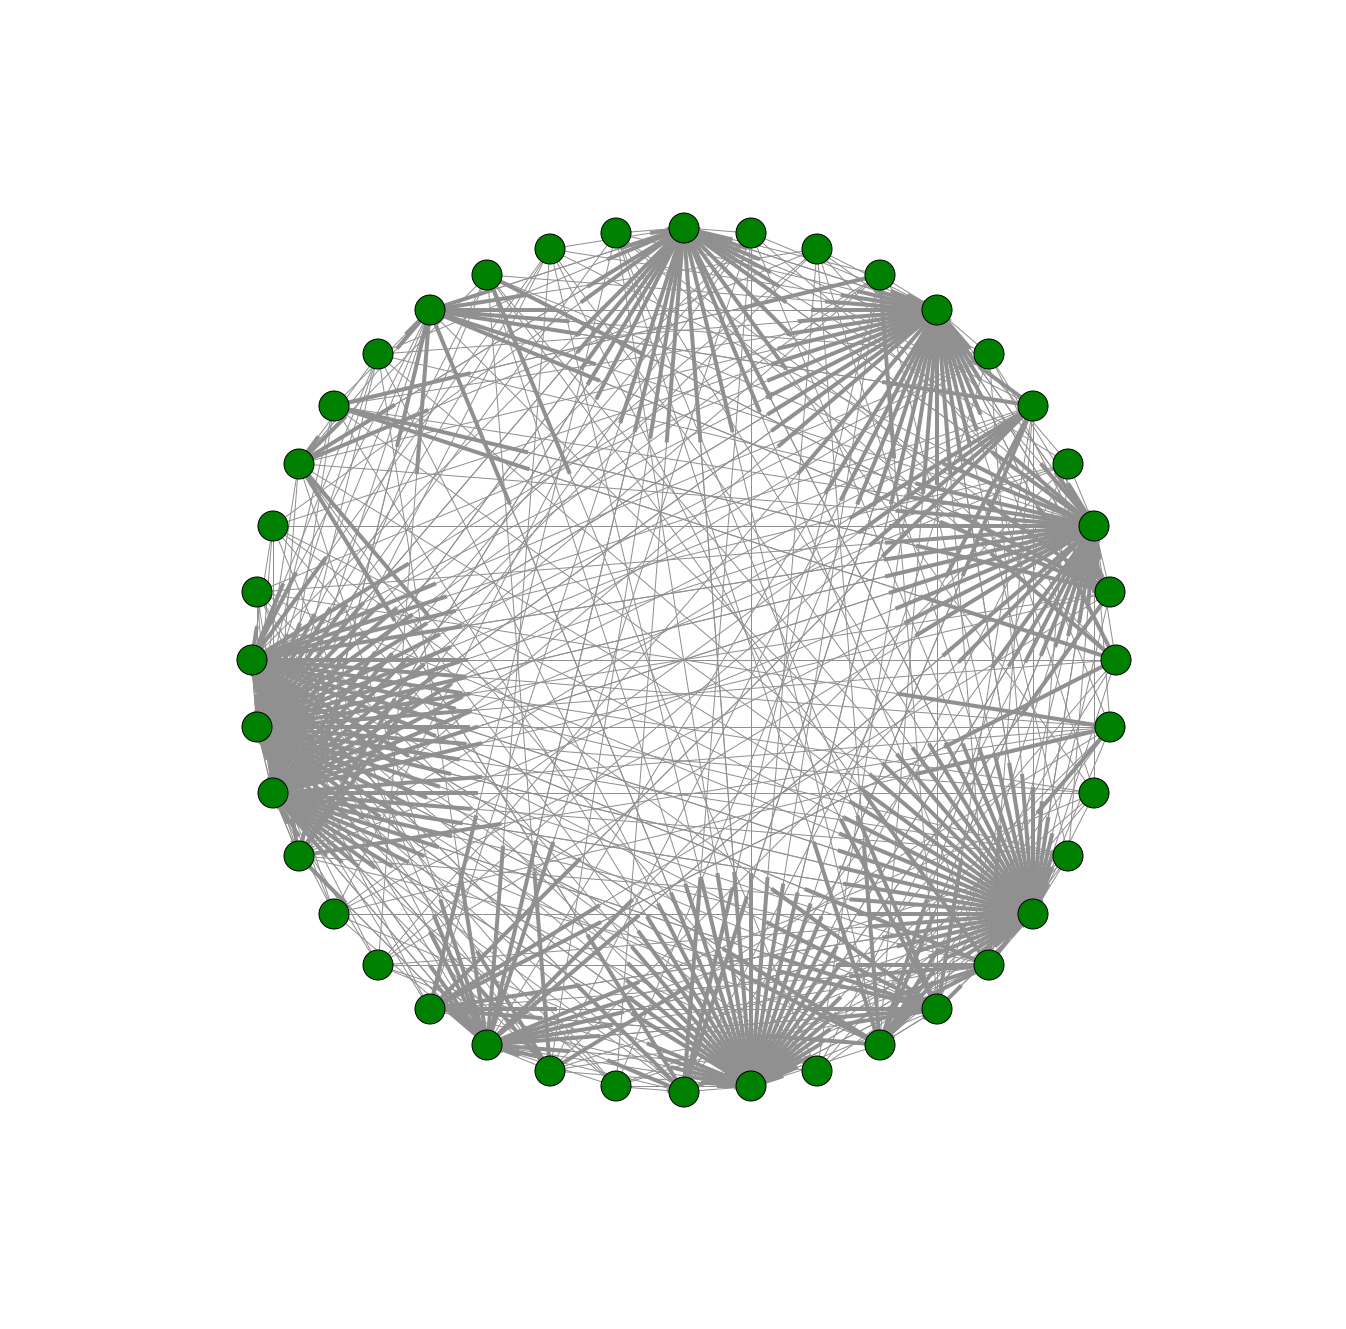

In [37]:
plt.figure(figsize=(18,18))            
nx.draw_circular(G,node_color='g', edge_color='#909090', node_size=900)
plt.axis('equal')

In [42]:
from IPython.core.display import HTML
def  css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()